## Lab 3: final challenges

__Вам предлагается решить задачу классификации сигналов (вы уже встречались с ней во второй лабораторной работе) или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

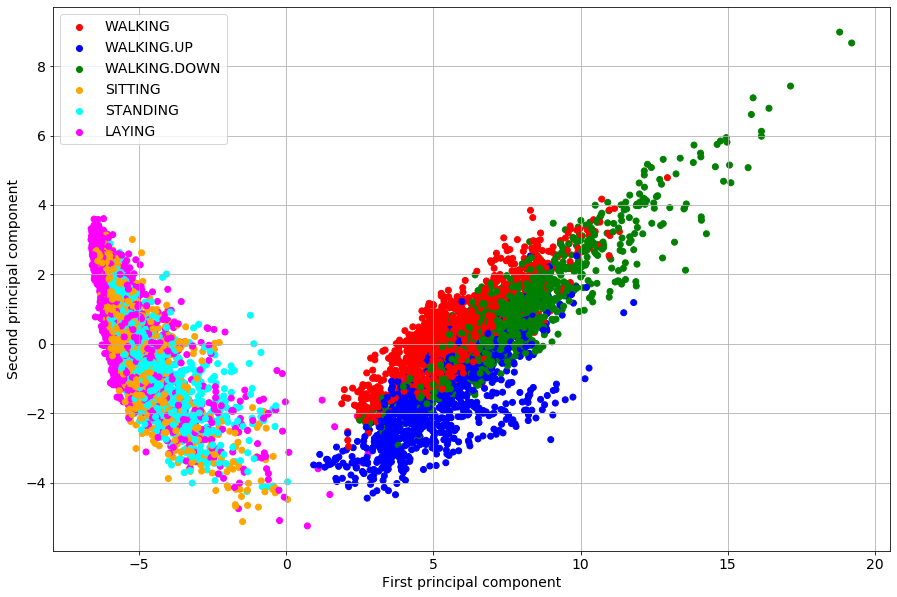

In [3]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [4]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [5]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [6]:
y_train = y_train.reshape((y_train.size,))
y_test = y_test.reshape((y_test.size,))

In [7]:
X_train = np.transpose(X_train, [0, 2, 1])
X_test = np.transpose(X_test, [0, 2, 1])

#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [8]:
%matplotlib inline
from time import time, sleep
import numpy as np
import math
import torch
import torch.nn as nn
import torch.tensor as T
import torchsummary
import matplotlib.pyplot as plt
from IPython import display

In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
            # (batch, 128, 9) -> (batch, 64, 18)
            nn.Conv1d(in_channels=9, out_channels=18, kernel_size=2),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=2),
            nn.BatchNorm1d(num_features=18),
            # (batch, 64, 18) -> (batch, 32, 36)
            nn.Conv1d(in_channels=18, out_channels=36, kernel_size=2),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=2),
            nn.BatchNorm1d(num_features=36),
            # (batch, 32, 36) -> (batch, 16, 72)
            nn.Conv1d(in_channels=36, out_channels=72, kernel_size=2),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=2),
            nn.BatchNorm1d(num_features=72),
            # (batch, 15, 72) -> (batch, 6)
            nn.Flatten(),
            nn.Linear(in_features=15*72, out_features=6),
        )
        
    def forward(self, inp):
        return self.model(inp)

In [10]:
model = Model()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [11]:
torchsummary.summary(model.to('cuda'), (9, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 18, 127]             342
               ELU-2              [-1, 18, 127]               0
         MaxPool1d-3               [-1, 18, 63]               0
       BatchNorm1d-4               [-1, 18, 63]              36
            Conv1d-5               [-1, 36, 62]           1,332
               ELU-6               [-1, 36, 62]               0
         MaxPool1d-7               [-1, 36, 31]               0
       BatchNorm1d-8               [-1, 36, 31]              72
            Conv1d-9               [-1, 72, 30]           5,256
              ELU-10               [-1, 72, 30]               0
        MaxPool1d-11               [-1, 72, 15]               0
      BatchNorm1d-12               [-1, 72, 15]             144
          Flatten-13                 [-1, 1080]               0
           Linear-14                   

In [12]:
# batch generator
def get_batches(X, Y, batch_size):

    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [13]:
def train_model(model, X_train, y_train, X_test, y_test, criterion, optim, n_epochs: int):
    '''
    model: нейросеть для обучения
    train_loader: загрузчик данных
    loss: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    test_loss = []
    test_accuracy = []
    
    X_train = X_train.cuda()
    y_train = y_train.cuda()
    X_test = X_test.cuda()
    y_test = y_test.cuda()

    for epoch in range(n_epochs):
        
        ep_train_loss = []
        ep_test_loss = []
        ep_test_accuracy = []

        model.train(True)
        for X_batch, y_batch in get_batches(X_train, y_train, 256):
            
            optim.zero_grad()

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optim.step()

            ep_train_loss.append(loss.item())

        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in  get_batches(X_test, y_test, 256):

                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)

                y_pred = (torch.argmax(y_pred, dim=1))
                accuracy = (y_batch == y_pred).float().mean()

                ep_test_loss.append(loss.item())
                ep_test_accuracy.append(accuracy.to('cpu'))

        train_loss.append(np.mean(ep_train_loss))
        test_loss.append(np.mean(ep_test_loss))
        test_accuracy.append(np.mean(ep_test_accuracy))

        print(f"{epoch} epoch results:")
        print(f"\t training loss: {train_loss[-1]:.6f}")
        print(f"\t test loss: {test_loss[-1]:.6f}")
        print(f"\t test accuracy: {test_accuracy[-1]:.3f}")

    return train_loss, test_loss, test_accuracy

In [14]:
train_loss, test_loss, test_accuracy = train_model(model,  T(X_train), T(y_train, dtype=torch.long),T(X_test), T(y_test, dtype=torch.long), criterion, optim, 21)

0 epoch results:
	 training loss: 0.655059
	 test loss: 0.808621
	 test accuracy: 0.672
1 epoch results:
	 training loss: 0.287150
	 test loss: 0.432642
	 test accuracy: 0.835
2 epoch results:
	 training loss: 0.196134
	 test loss: 0.384972
	 test accuracy: 0.865
3 epoch results:
	 training loss: 0.164105
	 test loss: 0.400171
	 test accuracy: 0.860
4 epoch results:
	 training loss: 0.153842
	 test loss: 0.307201
	 test accuracy: 0.897
5 epoch results:
	 training loss: 0.131273
	 test loss: 0.305925
	 test accuracy: 0.901
6 epoch results:
	 training loss: 0.129978
	 test loss: 0.278711
	 test accuracy: 0.905
7 epoch results:
	 training loss: 0.124394
	 test loss: 0.276373
	 test accuracy: 0.911
8 epoch results:
	 training loss: 0.125007
	 test loss: 0.255050
	 test accuracy: 0.916
9 epoch results:
	 training loss: 0.122735
	 test loss: 0.277305
	 test accuracy: 0.915
10 epoch results:
	 training loss: 0.119153
	 test loss: 0.250033
	 test accuracy: 0.905
11 epoch results:
	 training lo

In [15]:
def plot_train_process(train_loss, test_loss, test_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(test_loss, label='test')
    axes[0].legend()

    axes[1].set_title('Accuracy')
    axes[1].plot(test_accuracy, label='test accuracy')
    axes[1].plot([0.91] * len(test_accuracy), label='goal (91%)')
    axes[1].legend()

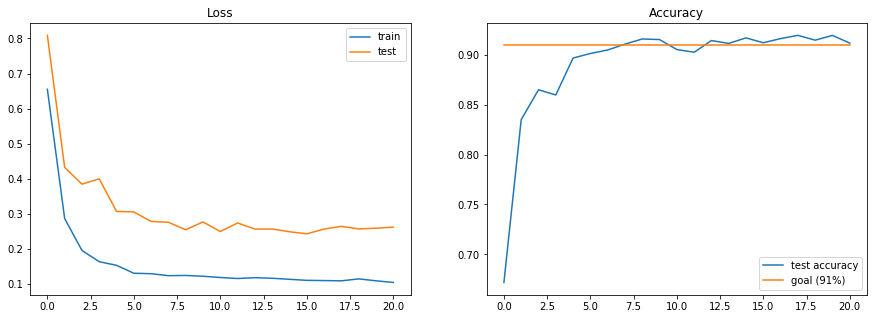

In [16]:
plot_train_process(train_loss, test_loss, test_accuracy)

$\textbf{Вывод:}$ с самого начала я решила использовать простую свёрточную нейросеть из чередующихся слоёв свёртки и пуллинга. Не помню, какой именно точности мне удалось достичь таким способом, но кажется примерно 86%. Затем я решила добавить между каждым слоем свёртки и пуллинга слой активации ELU, и значение точности выросло до 89%. Убрав ELU и добавив BatchNorm, я подняла значение точности до почти 91%. И наконец я объединила все ранее используемые слои, после чего точность резко увеличилась до 91+ % (см график). Замечу также, что с каждым подходом значения лосса как на обучающей, так и на тренировочной выборке падали, а переобучения не происходило совсем (хотя количество параметров сети больше размера обучающей выборки).

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [1]:
import torch
from torchvision import transforms
from torchsummary import summary
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import time
from collections import defaultdict
from tqdm.auto import tqdm
import os

In [3]:
# Path to a directory with image dataset and subfolders for training, validation and final testing
DATA_PATH = r"data"

# Number of threads for data loader
NUM_WORKERS = 4

# Image size: even though image sizes are bigger than 96, we use this to speed up training
SIZE_H = SIZE_W = 128

# Number of classes in the dataset
NUM_CLASSES = 50

# Epochs: number of passes over the training data, we use it this small to reduce training babysitting time
EPOCH_NUM = 30

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 256

# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 128

In [4]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),        # scaling images to fixed size
    transforms.ToTensor(),                      # converting to tensors
])

In [5]:
transformer_val = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomRotation(15),
    transforms.Resize((SIZE_H, SIZE_W)),
    transforms.ToTensor(),
])

In [6]:
# load dataset using torchvision.datasets.ImageFolder
train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train'), transform=transformer)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'val'), transform=transformer_val)

In [7]:
n_train, n_val = len(train_dataset), len(val_dataset)

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [9]:
def plot_from_batch_generator(batch_gen):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    class_names = batch_gen.dataset.classes
    for i in range(grid_size[0] * grid_size[1]):
        
        # read images from batch to numpy.ndarray and change axes order [C, H, W] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])
        
        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(batch_image_ndarray, 0, 1)
        
        # display batch samples with labels
        sample_title = 'Label = %d (%s)' % (label_batch[i], class_names[label_batch[i]])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)
    pass

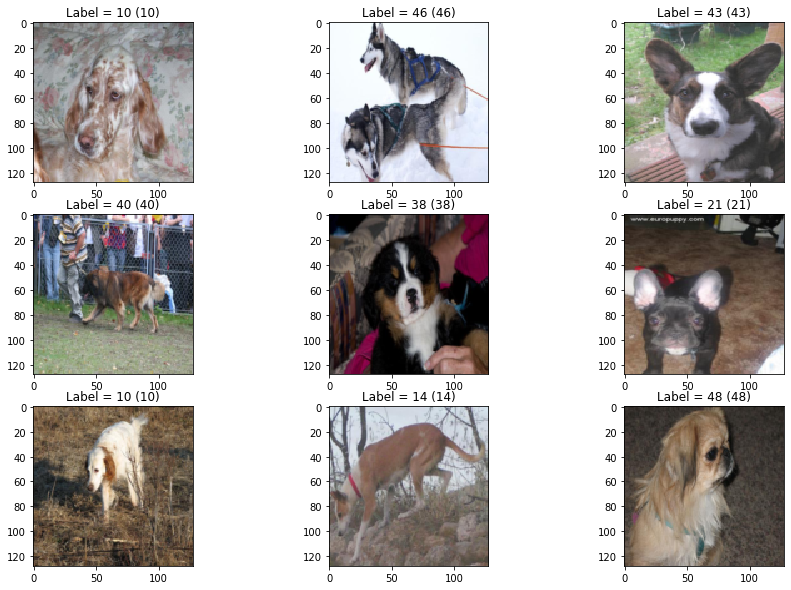

In [10]:
plot_from_batch_generator(train_loader)

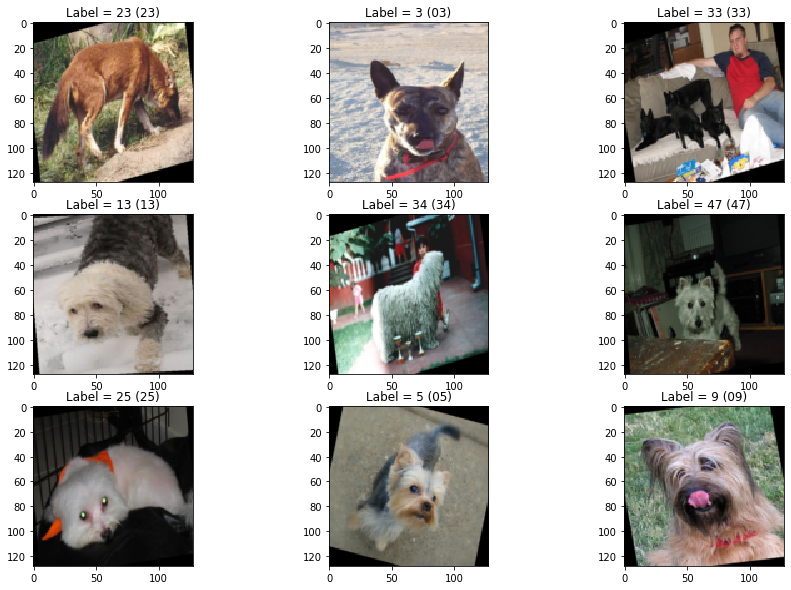

In [11]:
plot_from_batch_generator(val_loader)

In [12]:
model_resnet18 = torchvision.models.resnet18(pretrained=True)

In [13]:
# Disable gradient updates for all the layers except  the final layer
for p in model_resnet18.parameters():
    p.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_feat = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_feat, NUM_CLASSES)

# Use available device for calculations
model_resnet18 = model_resnet18.cuda()

In [14]:
optimizer = torch.optim.Adam(model_resnet18.fc.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [15]:
summary(model_resnet18, (3, SIZE_H, SIZE_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [16]:
def train_model(model, train_loader, test_loader, criterion, optimizer, n_epochs: int):
    '''
    model: нейросеть для обучения
    train_loader, test_loader: загрузчики данных
    criterion: целевая метрика (которую будем оптимизировать)
    optimizer: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    test_loss = []
    test_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_test_loss = []
        ep_test_accuracy = []

        model.train(True)
        for X_batch, y_batch in train_loader:

            optimizer.zero_grad()

            predictions = model(X_batch.cuda())
            loss = criterion(predictions, y_batch.cuda())
            loss.backward()
            optimizer.step()

            ep_train_loss.append(loss.item())

        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in test_loader:

                predictions = model(X_batch.cuda())
                loss = criterion(predictions, y_batch.cuda())

                y_pred = (torch.argmax(predictions, dim=1)).to('cpu')
                accuracy = (y_batch == y_pred).float().mean()

                ep_test_loss.append(loss.item())
                ep_test_accuracy.append(accuracy)

        train_loss.append(np.mean(ep_train_loss))
        test_loss.append(np.mean(ep_test_loss))
        test_accuracy.append(np.mean(ep_test_accuracy))

        print(f"{epoch} epoch results:")
        print(f"\t training loss: {train_loss[-1]:.6f}")
        print(f"\t test loss: {test_loss[-1]:.6f}")
        print(f"\t test accuracy: {test_accuracy[-1]:.3f}")

    return train_loss, test_loss, test_accuracy

In [17]:
train_loss, test_loss, test_accuracy = train_model(model_resnet18, train_loader, val_loader, criterion, optimizer, 31)

0 epoch results:
	 training loss: 3.248914
	 test loss: 2.796143
	 test accuracy: 0.338
1 epoch results:
	 training loss: 2.092530
	 test loss: 2.171190
	 test accuracy: 0.481
2 epoch results:
	 training loss: 1.683683
	 test loss: 1.914235
	 test accuracy: 0.535
3 epoch results:
	 training loss: 1.483650
	 test loss: 1.819429
	 test accuracy: 0.547
4 epoch results:
	 training loss: 1.366994
	 test loss: 1.739640
	 test accuracy: 0.560
5 epoch results:
	 training loss: 1.273277
	 test loss: 1.677347
	 test accuracy: 0.570
6 epoch results:
	 training loss: 1.195924
	 test loss: 1.618750
	 test accuracy: 0.583
7 epoch results:
	 training loss: 1.136148
	 test loss: 1.575943
	 test accuracy: 0.587
8 epoch results:
	 training loss: 1.085854
	 test loss: 1.539827
	 test accuracy: 0.592
9 epoch results:
	 training loss: 1.040126
	 test loss: 1.534275
	 test accuracy: 0.588
10 epoch results:
	 training loss: 1.000771
	 test loss: 1.512419
	 test accuracy: 0.589
11 epoch results:
	 training lo

In [19]:
def plot_train_process(train_loss, test_loss, test_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(test_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Accuracy')
    axes[1].plot(test_accuracy, label='validation accuracy')
    axes[1].legend()

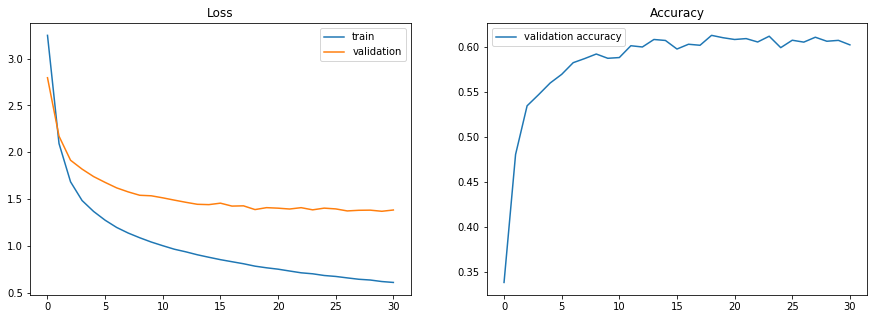

In [20]:
plot_train_process(train_loss, test_loss, test_accuracy)

In [21]:
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'test'), transform=transformer)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [72]:
test_predictions = []
test_predictions = []
y_test = []
    
model_resnet18.train(False)
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        
        predictions = model_resnet18(X_batch.cuda())
        y_pred = (torch.argmax(predictions, dim=1)).to('cpu')
        accuracy = (y_batch == y_pred).float().mean()
        test_accuracy.append(accuracy)
        test_predictions.append(y_pred)
        y_test.append(y_batch)

In [73]:
from functools import reduce
y_pred = reduce(lambda x,y: torch.cat((x,y)), test_predictions)
y_true = reduce(lambda x,y: torch.cat((x,y)), y_test)

In [76]:
(y_true == y_pred).float().mean()

tensor(0.8745)

In [74]:
y_pred[:100]

tensor([ 2, 45, 34, 30, 11, 28, 42, 20,  3, 18,  4, 21, 36, 11, 36, 19, 38, 35,
        13, 20, 14, 45,  7, 31, 32,  4, 14, 16, 42, 38,  4, 19,  2, 24, 41, 32,
        28,  6,  5,  1, 27, 16, 48, 42, 19, 44, 34, 20, 34,  2, 40, 24,  1, 27,
        42,  8, 30, 11, 38, 33, 30, 49, 20, 13, 14, 14, 19, 35,  2, 23, 30, 17,
         3, 21, 44, 38, 44, 29,  2, 16, 42,  7, 41,  0, 40, 15, 17,  0,  3, 11,
        13, 45, 24,  5, 18, 49, 29, 49,  2, 30])

In [75]:
y_true[:100]

tensor([ 2, 45, 34, 30, 11, 28, 42, 20,  3, 49, 35, 21, 36, 11, 37, 19, 38, 35,
        13, 20, 39, 45,  7, 31, 32,  4, 14, 16, 42, 38,  4, 19,  9, 44, 41, 32,
        28,  6,  5,  1, 27, 10, 14, 42, 19, 44, 34, 20, 34,  2, 40, 24,  1, 27,
        42,  8, 30, 11, 38, 33, 30, 49, 20, 13, 14, 14, 19,  9,  2, 23, 30, 17,
        12, 21, 44, 38, 44, 29,  2, 16, 42,  7, 41,  0, 40, 34, 17,  0,  3, 11,
        13, 45, 24,  5,  9, 46, 29, 49,  2, 30])

In [68]:
import re
import csv

with open('results.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for name, label in zip(test_dataset.imgs, labels):
        res = re.sub(r"data\\test\\0\\_ \(", "", name[0])
        res = re.sub(r"\).jpeg", "", res)
        writer.writerow([res, label.item()])

$\textbf{Вывод:}$ в этой задаче для оптимизации процесса обучения я решила использовать fine-tuning и взяла готовую модель resnet18. В качестве валидационной выборки была взята часть тренировочной с использованием трансформаций (отражение, поворот), на которой, к сожалению, не удалось достичь высокого значения точности. Далее были получены предсказания для тестовой выборки, которые будут приложены к лабе.